# Compare CESM2 historic conditions in line with ERA5

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cmocean
sys.path.append('/home/users/birgal/')
# from nemo_python_git.grid import region_mask

In [2]:
base_dir  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
cesm2_dir = f'{base_dir}climate-forcing/CESM2/LE2/'
era5_dir  = f'{base_dir}ERA5-forcing/'

In [6]:
ens_strs = ['1011.001', '1031.002', '1051.003', '1071.004', '1091.005', '1111.006', '1131.007', '1151.008', '1171.009', '1191.010']
var_mapping = {'TREFHT':'t2m','FSDS':'msdwswrf','FLDS':'msdwlwrf','QREFHT':'sph2m', 'PRECS':'msr', 'PRECT':'mtpr', 'PSL':'msl'}

#FLDS 1031, 1091, 1151 have some weird values

In [41]:
ds_cesm2_bias = xr.open_dataset(f'{cesm2_dir}bias-corrected/ens1011.001/seasonal_angle_landfilled/{var}_domain_mean_timeseries1.nc').resample(time="1Y").mean()

<xarray.Dataset> Size: 5MB
Dimensions:   (time: 55152)
Coordinates:
  * time      (time) datetime64[ns] 441kB 1900-01-01 1900-01-02 ... 2050-12-31
Data variables:
    1011.001  (time) float64 441kB 278.3 280.0 287.8 287.7 ... 301.0 301.7 300.1
    1031.002  (time) float64 441kB 280.2 281.3 283.8 288.6 ... 295.1 294.4 294.3
    1051.003  (time) float64 441kB 287.0 289.9 289.4 286.0 ... 291.3 292.1 293.6
    1071.004  (time) float64 441kB 289.1 288.8 289.3 292.1 ... 295.1 294.9 298.7
    1091.005  (time) float64 441kB 292.0 291.2 295.6 297.0 ... 299.6 300.8 297.7
    1111.006  (time) float64 441kB 285.4 285.0 287.6 289.1 ... 292.9 292.6 293.4
    1131.007  (time) float64 441kB 285.1 288.9 290.7 290.8 ... 297.7 297.4 299.6
    1151.008  (time) float64 441kB 290.8 287.8 285.3 285.7 ... 297.9 298.3 298.7
    1171.009  (time) float64 441kB 291.0 289.1 288.4 287.1 ... 288.2 291.2 296.5
    1191.010  (time) float64 441kB 281.0 282.3 280.9 281.5 ... 290.0 292.9 293.2

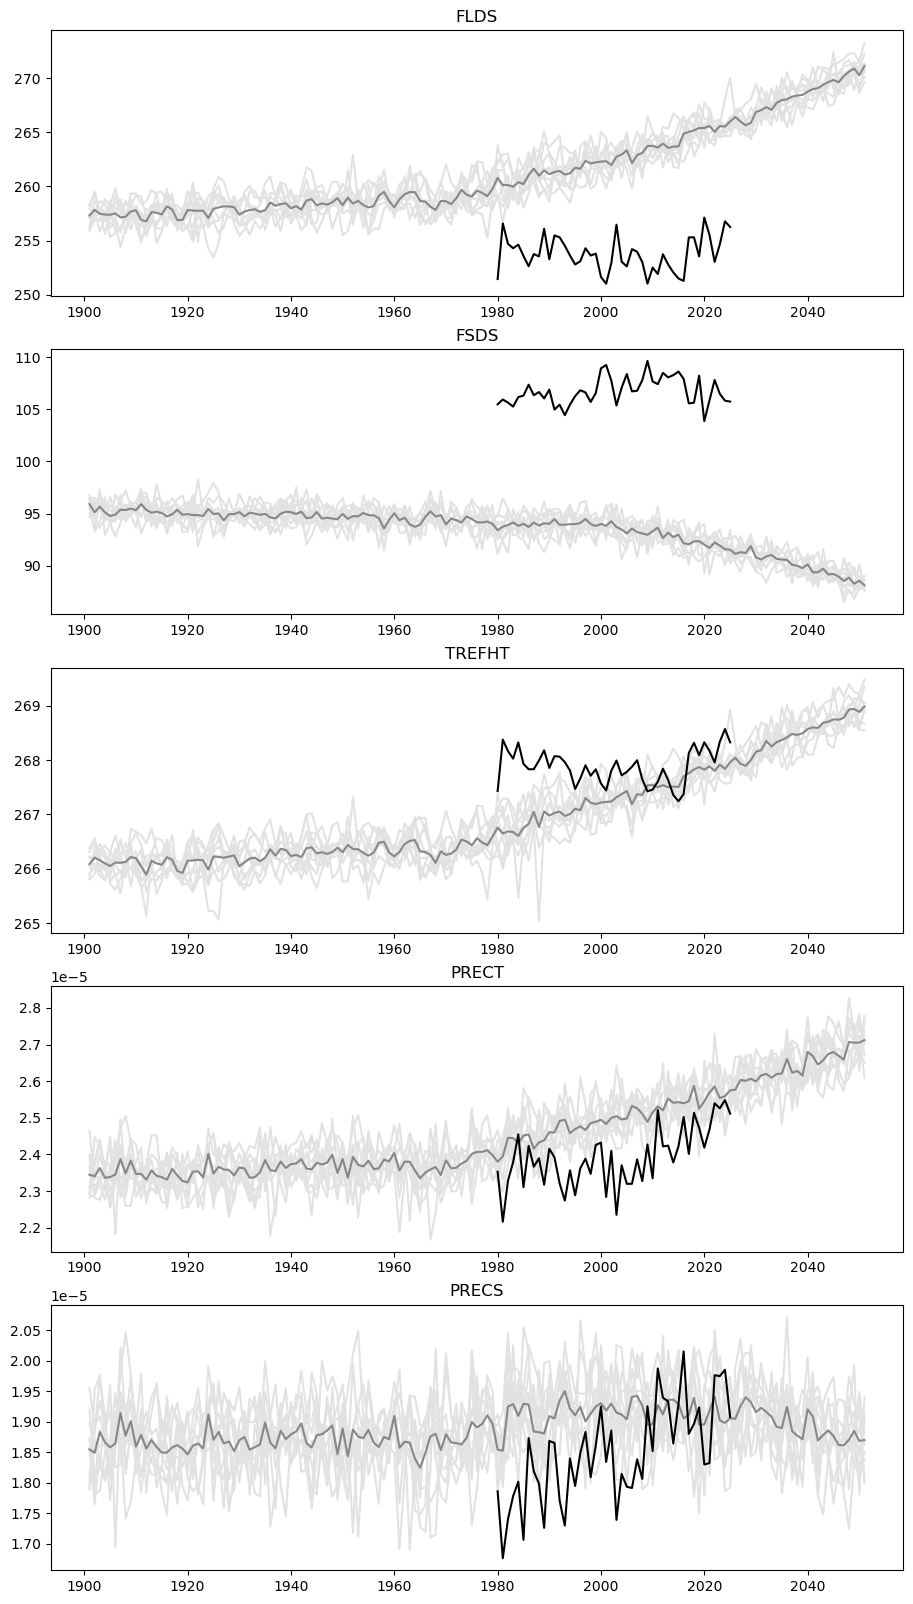

In [8]:
fig, ax = plt.subplots(5,1, figsize=(11,20))

for v, var in enumerate(['FLDS','FSDS','TREFHT','PRECT','PRECS']):
    ds_cesm2 = xr.open_dataset(f'{cesm2_dir}ensemble_mean/{var}_domain_mean_timeseries1.nc').resample(time="1YE").mean()
    ds_era5  = xr.open_dataset(f'{era5_dir}climatology/{var}_domain_mean_timeseries.nc').resample(time="1YE").mean()
    
    ds_cesm2_sum = 0
    for ens in ens_strs: 
        ax[v].plot(ds_cesm2.time, ds_cesm2[ens], c='#e1e3e2')
        ds_cesm2_sum = ds_cesm2_sum + ds_cesm2[ens]
    
    # add line for ensemble mean
    ax[v].plot(ds_cesm2.time, ds_cesm2_sum/len(ens_strs), c='#878787')
    # add line for bias corrected mean

    ax[v].plot(ds_era5.time, ds_era5[var_mapping[var]], c='k')
    ax[v].set_title(var)

In [28]:
cesm2_FLDS_ens_ts

<xarray.Dataset> Size: 35kB
Dimensions:   (time: 731)
Coordinates:
  * time      (time) datetime64[ns] 6kB 1979-01-01 1979-01-02 ... 1980-12-31
Data variables:
    1011.001  (time) float64 6kB dask.array<chunksize=(1,), meta=np.ndarray>
    1031.002  (time) float64 6kB dask.array<chunksize=(1,), meta=np.ndarray>
    1051.003  (time) float64 6kB dask.array<chunksize=(1,), meta=np.ndarray>
    1071.004  (time) float64 6kB dask.array<chunksize=(1,), meta=np.ndarray>
    1091.005  (time) float64 6kB dask.array<chunksize=(1,), meta=np.ndarray>